In [2]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, MBartForConditionalGeneration, \
    MT5ForConditionalGeneration
import os
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from typing import List, Union, Dict
from transformers import AutoModelForSeq2SeqLM
import torch
from transformers import MBartConfig

In [3]:
def cos_sim(named_weights: Dict[str, torch.Tensor], dim: int) -> Dict[str, torch.Tensor]:
    sim: Dict[str, torch.Tensor] = {}
    names = list(named_weights.keys())
    for i in range(len(names) - 1):
        m_i = names[i]
        for j in range(i + 1, len(names)):
            m_j = names[j]
            with torch.no_grad():
                sim[f"{m_i},{m_j}"] = torch.nn.functional.cosine_similarity(named_weights[m_i], named_weights[m_j],
                                                                            dim=dim).numpy()
    return sim

In [4]:
m1_model = AutoModelForSeq2SeqLM.from_pretrained(
    "/home/n.dallanoce/PyCharm/pretraining/weights/S2_mbart_pre_en-fr(M1)/checkpoint-180000", output_attentions=True)
m2_model = AutoModelForSeq2SeqLM.from_pretrained(
    "/home/n.dallanoce/PyCharm/pretraining/weights/S2_mbart_pre_en-fr_de(M2)/checkpoint-180000", output_attentions=True)
m3_model = AutoModelForSeq2SeqLM.from_pretrained(
    "/home/n.dallanoce/PyCharm/pretraining/weights/S2_mbart_pre_en-fr_de_es(M3)/checkpoint-180000",
    output_attentions=True)
rnd_model: MBartForConditionalGeneration = MBartForConditionalGeneration(MBartConfig(encoder_layers=6, decoder_layers=6,
                                                                                     encoder_ffn_dim=2048,
                                                                                     decoder_ffn_dim=2048,
                                                                                     encoder_attention_heads=8,
                                                                                     decoder_attention_heads=8,
                                                                                     d_model=512, max_length=128,
                                                                                     vocab_size=m1_model.config.vocab_size,
                                                                                     dropout=0.1))
de_model: MBartForConditionalGeneration = AutoModelForSeq2SeqLM.from_pretrained(
    "/home/n.dallanoce/PyCharm/pretraining/weights/mbart_pre_en-de/checkpoint-180000", output_attentions=True)
col_names = ['(m1, m2)', '(m2, m3)', '(m1, m3)', '(m2, de)', '(m2, rnd)']

# Analisys on Embeddings

In [5]:
embed_m1 = m1_model.model.shared.weight
embed_m2 = m2_model.model.shared.weight
embed_m3 = m3_model.model.shared.weight
embed_de = de_model.model.shared.weight
embed_rnd = rnd_model.model.shared.weight

              0         1         2         3         4
0      0.758732  0.832812  0.806788 -0.122321 -0.003188
1      0.818844  0.871552  0.835344 -0.100156  0.000000
2      0.960424  0.956427  0.891191 -0.026989  0.009568
3      0.813527  0.871365  0.829483 -0.109195  0.026614
4      0.817218  0.871776  0.832394 -0.096748  0.015065
...         ...       ...       ...       ...       ...
32025  0.812272  0.872402  0.828978 -0.111827  0.016641
32026  0.815439  0.871791  0.831623 -0.084351 -0.062052
32027  0.814725  0.871866  0.833238 -0.092881  0.029151
32028  0.814339  0.868988  0.829883 -0.095818 -0.003665
32029  0.824440  0.872121  0.840578 -0.102650 -0.030115

[32030 rows x 5 columns]


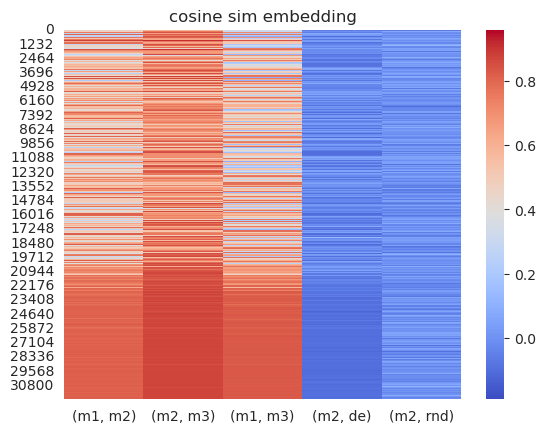

In [6]:
with torch.no_grad():
    df_emb = pd.DataFrame([torch.nn.functional.cosine_similarity(embed_m1, embed_m2).numpy(),
                           torch.nn.functional.cosine_similarity(embed_m2, embed_m3).numpy(),
                           torch.nn.functional.cosine_similarity(embed_m1, embed_m3).numpy(),
                           torch.nn.functional.cosine_similarity(embed_m2, embed_de).numpy(),
                           torch.nn.functional.cosine_similarity(embed_m2, embed_rnd).numpy()])

print(df_emb.T)
g = sns.heatmap(df_emb.T, cmap="coolwarm")
g.set(title="cosine sim embedding")
g.set_xticklabels(col_names)
plt.show()

In [7]:
with torch.no_grad():
    print(torch.norm(embed_m1 - embed_m2))
    print(torch.norm(embed_m2 - embed_m3))
    print(torch.norm(embed_m1 - embed_m3))
    print(torch.norm(embed_de - embed_m2))
    print(torch.norm(embed_rnd - embed_m2))

tensor(328.6555)
tensor(340.6498)
tensor(435.2476)
tensor(505.7484)
tensor(419.8259)


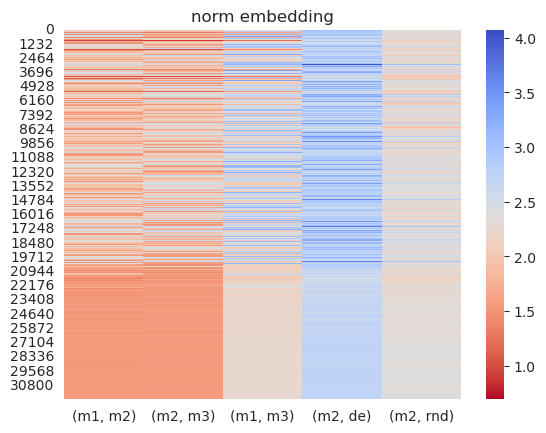

              0         1         2         3         4
0      1.507746  1.644024  2.142052  2.619115  2.202534
1      1.545685  1.558267  2.248333  2.726764  2.311221
2      0.703443  0.757873  1.258441  2.598814  2.069152
3      1.550613  1.558868  2.251326  2.741899  2.343119
4      1.545859  1.556739  2.250650  2.724614  2.346578
...         ...       ...       ...       ...       ...
32025  1.552619  1.555434  2.256777  2.737102  2.345316
32026  1.549355  1.557928  2.250001  2.716813  2.387263
32027  1.550958  1.555985  2.250607  2.717957  2.340693
32028  1.548616  1.562282  2.238065  2.729826  2.359569
32029  1.538112  1.553915  2.250211  2.701226  2.356046

[32030 rows x 5 columns]


In [8]:
norm_emb = np.zeros((embed_m1.shape[0], 5))
with torch.no_grad():
    for i in range(embed_m1.shape[0]):
        norm_emb[i, 0] = torch.norm(embed_m1[i, :] - embed_m2[i, :])
        norm_emb[i, 1] = torch.norm(embed_m2[i, :] - embed_m3[i, :])
        norm_emb[i, 2] = torch.norm(embed_m1[i, :] - embed_m3[i, :])
        norm_emb[i, 3] = torch.norm(embed_m2[i, :] - embed_de[i, :])
        norm_emb[i, 4] = torch.norm(embed_m2[i, :] - embed_rnd[i, :])

g = sns.heatmap(norm_emb, cmap="coolwarm_r")
g.set(title="norm embedding")
g.set_xticklabels(col_names)
plt.show()
print(pd.DataFrame(norm_emb))

# Analysis on Encoder Last Hidden state

In [9]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("nikodallanoce/mbart-cc4-vanilla-32k-5", src_lang="de_DE")
tok_out = tokenizer("Hello how are you? This is my dog.", return_tensors="pt")
col_tokens = tokenizer.batch_decode(tok_out['input_ids'].squeeze())

with torch.no_grad():
    seq2seq_out_m1 = m1_model(**tok_out)
    seq2seq_out_m2 = m2_model(**tok_out)
    seq2seq_out_m3 = m3_model(**tok_out)
    seq2seq_out_de = de_model(**tok_out)
    seq2seq_out_rnd = rnd_model(**tok_out)

last_hidd_state_m1 = seq2seq_out_m1['encoder_last_hidden_state'].squeeze().T
last_hidd_state_m2 = seq2seq_out_m2['encoder_last_hidden_state'].squeeze().T
last_hidd_state_m3 = seq2seq_out_m3['encoder_last_hidden_state'].squeeze().T
last_hidd_state_de = seq2seq_out_de['encoder_last_hidden_state'].squeeze().T
last_hidd_state_rnd = seq2seq_out_rnd['encoder_last_hidden_state'].squeeze().T

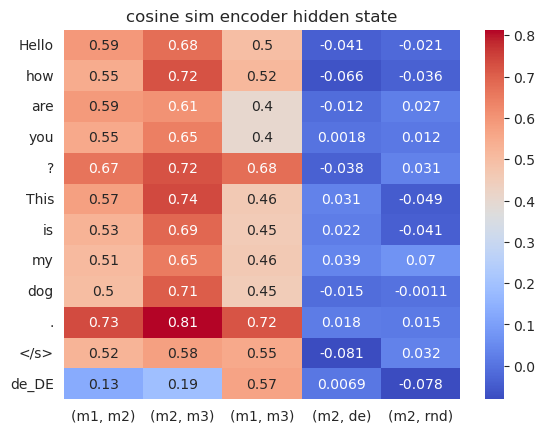

In [10]:
with torch.no_grad():
    cos_sim_hs_m1_m2 = torch.nn.functional.cosine_similarity(last_hidd_state_m1, last_hidd_state_m2, dim=0)
    cos_sim_hs_m2_m3 = torch.nn.functional.cosine_similarity(last_hidd_state_m2, last_hidd_state_m3, dim=0)
    cos_sim_hs_m1_m3 = torch.nn.functional.cosine_similarity(last_hidd_state_m1, last_hidd_state_m3, dim=0)
    cos_sim_hs_m2_de = torch.nn.functional.cosine_similarity(last_hidd_state_m2, last_hidd_state_de, dim=0)
    cos_sim_hs_rnd_de = torch.nn.functional.cosine_similarity(last_hidd_state_rnd, last_hidd_state_de, dim=0)
    df_cos_hs = pd.DataFrame(
        [cos_sim_hs_m1_m2.numpy(), cos_sim_hs_m2_m3.numpy(), cos_sim_hs_m1_m3.numpy(), cos_sim_hs_m2_de.numpy(),
         cos_sim_hs_rnd_de.numpy()],
        columns=col_tokens)

#print(df_cos_hs)
g = sns.heatmap(df_cos_hs.T, cmap="coolwarm", annot=True)
g.set(title="cosine sim encoder hidden state")
#g.set_xticks(range(len(df_cos_hs))) # <--- set the ticks first
g.set_xticklabels(col_names)
plt.yticks(rotation=0)
plt.show()

# Analysis on Logits

In [11]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("nikodallanoce/mbart-cc4-vanilla-32k-5", src_lang="de_DE", tgt_lang="de_DE")
tok_out = tokenizer("Hallo, wie geht's dir? Das ist <mask> Hund.", text_target="Hallo, wie geht's dir? Das ist mein Hund.", return_tensors="pt")
col_tokens = tokenizer.batch_decode(tok_out['input_ids'].squeeze())

In [12]:
with torch.no_grad():
    seq2seq_out_m1 = m1_model(**tok_out)
    seq2seq_out_m2 = m2_model(**tok_out)
    seq2seq_out_m3 = m3_model(**tok_out)
    seq2seq_out_de = de_model(**tok_out)
    seq2seq_out_rnd = rnd_model(**tok_out)

logits_m1 = seq2seq_out_m1['logits'].squeeze().T
logits_m2 = seq2seq_out_m2['logits'].squeeze().T
logits_m3 = seq2seq_out_m3['logits'].squeeze().T
logits_de = seq2seq_out_de['logits'].squeeze().T
logits_rnd = seq2seq_out_rnd['logits'].squeeze().T

In [13]:
logits_m1.shape

torch.Size([32030, 14])

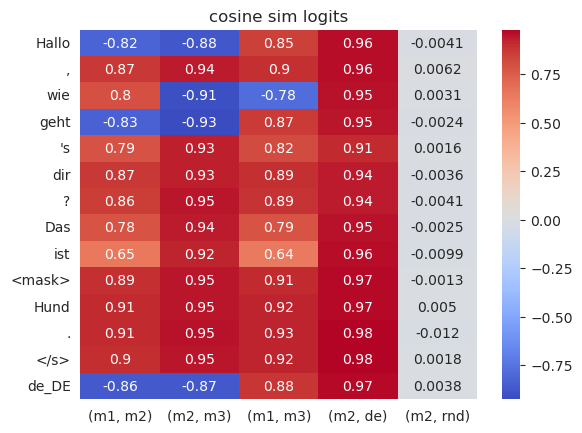

In [44]:
with torch.no_grad():
    cos_sim_lg_m1_m2 = torch.nn.functional.cosine_similarity(logits_m1, logits_m2, dim=0)
    cos_sim_lg_m2_m3 = torch.nn.functional.cosine_similarity(logits_m2, logits_m3, dim=0)
    cos_sim_lg_m1_m3 = torch.nn.functional.cosine_similarity(logits_m1, logits_m3, dim=0)
    cos_sim_lg_m2_de = torch.nn.functional.cosine_similarity(logits_m2, logits_de, dim=0)
    cos_sim_lg_rnd_de = torch.nn.functional.cosine_similarity(logits_rnd, logits_de, dim=0)
    df_cos_lg = pd.DataFrame(
        [cos_sim_lg_m1_m2.numpy(), cos_sim_lg_m2_m3.numpy(), cos_sim_lg_m1_m3.numpy(), cos_sim_lg_m2_de.numpy(),
         cos_sim_lg_rnd_de.numpy()],
        columns=col_tokens)

g = sns.heatmap(df_cos_lg.T, cmap="coolwarm", annot=True)
g.set(title="cosine sim logits")
g.set_xticklabels(col_names)
plt.yticks(rotation=0)
plt.show()

In [13]:
# lg_w = {"m1": logits_m1, "m2": logits_m2, "m3": logits_m3, "de": logits_de, "rnd": logits_rnd}
# cos_sim_lg = cos_sim(lg_w, dim=0)
# #print(cos_sim_lg)
# df_cos_lg = pd.DataFrame(
#     cos_sim_lg.values(),
#     columns=col_tokens)
#
# g = sns.heatmap(df_cos_lg.T, cmap="coolwarm", annot=True)
# g.set(title="cosine sim logits")
# g.set_xticklabels(cos_sim_lg.keys())
# plt.show()

# Analysis on Attentions

In [14]:
from transformers import PreTrainedModel
from bertviz import model_view
def generate_attention_graphs(models: Dict[str, PreTrainedModel], tok_out) -> str:
    html_code = ""
    labels = tok_out['labels']
    decoder_input_ids = torch.zeros_like(labels)
    decoder_input_ids[:, 0] = labels[:, -1]
    decoder_input_ids[:, 1:] = labels[:, :-1]
    for m_k, m in models.items():
        with torch.no_grad():
            att = m(input_ids=out_tok['input_ids'], decoder_input_ids=decoder_input_ids)
        encoder_text = tokenizer.convert_ids_to_tokens(tok_out["input_ids"].squeeze())
        decoder_text = tokenizer.convert_ids_to_tokens(decoder_input_ids.squeeze())
        mv = model_view(
            encoder_attention=att.encoder_attentions,
            decoder_attention=att.decoder_attentions,
            cross_attention=att.cross_attentions,
            encoder_tokens=encoder_text,
            decoder_tokens=decoder_text,
            html_action="return",
            display_mode="light"
        )

        html_code += f"<h3> {m_k} </h3> \n" + mv.data

    return html_code

In [15]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("nikodallanoce/mbart-cc4-vanilla-32k-5", src_lang="en_XX", tgt_lang="de_DE")

In [16]:
src_txt, tgt_txt = "Hello how are you? This is my dog.", "Hallo, wie geht's dir? Das ist mein Hund."
out_tok = tokenizer(src_txt, text_target=tgt_txt, return_tensors="pt", add_special_tokens=True)
print(generate_attention_graphs({"m1": m1_model, "m2": m2_model, "de" : de_model}, out_tok))

<h3> m1 </h3> 
<script src="https://cdnjs.cloudflare.com/ajax/libs/require.js/2.3.6/require.min.js"></script>      
        <div id="bertviz-6daecbfaade24c1a9add9d7c3c5e38bb" style="font-family:'Helvetica Neue', Helvetica, Arial, sans-serif;">
            <span style="user-select:none">
                Attention: <select id="filter"><option value="0">Encoder</option>
<option value="1">Decoder</option>
<option value="2">Cross</option></select>
            </span>
            <div id='vis'></div>
        </div>
    
<script type="text/javascript">
/**
 * @fileoverview Transformer Visualization D3 javascript code.
 *
 * Based on: https://github.com/tensorflow/tensor2tensor/blob/master/tensor2tensor/visualization/attention.js
 *
 * Change log:
 *
 * 02/01/19  Jesse Vig   Initial implementation
 * 12/31/20  Jesse Vig   Support multiple visualizations in single notebook.
 * 01/19/21  Jesse Vig   Support light/dark modes
 * 02/06/21  Jesse Vig   Move require config from separate jupyter noteb